In [7]:
import argparse
import numpy as np
import pickle
import time
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime


from dataset import get_dataloader
from tqdm import tqdm
import random
from models.gated_tpp import *
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt

## 1-D Hawkes

In [143]:
def power_law_kernel(t):  
    
    return 0.2 * (0.5 + t)**(-1.3)


def exponential_kernel(t):
    alpha = 0.2
    beta = 0.1
    
    return alpha*beta*np.exp(-t*beta)
    
def sin_kernel(t):
    

    t_c = np.copy(t)
    t_c[t_c>4] =0
    sin = np.sin(t_c)/8
    sin[sin <0] =0
    return sin

def squared_exponential_kernel(x, sigma=1, lengthscale=1, norm=1):

    return (sigma ** 2) * torch.exp(-(x ** 2) / lengthscale ** 2)




def polynomial_kernel(x1,x2, sigma=0, p=2):    
    
    return ((x1*x2).sum(-1) +sigma)**p

def rational_quadratic_kernel(x, sigma =1, alpha= 0.1, lengthscale = 0.01,norm = 1):
#     d = x ** norm
    d =x
    return (sigma ** 2) *(1+((d**2)/(alpha*lengthscale)))**(-alpha)


def sigmoid(x,l=0.1,s=0.1,b = 0.1,norm =2):
    d = x**norm
    return 1+torch.tanh((d-l)/s)

def power_law_kernel(t):  
    
    return 0.2 * (0.5 + t)**(-1.3)

def sin_kernel(t):
    

    t_c = np.copy(t)
    t_c[t_c>4] =0
    sin = np.sin(t_c)/8
    sin[sin <0] =0
    return sin


def get_moving_average(times,scores,step = 0.15,t_max = 200):
    
    t = []
    alpha = []
    
    index= 0
    for i in np.arange(step,t_max,step):
        avg_index = (times<i) & ( times >i - step)
        t.append(times[avg_index].mean().item())
        alpha.append(scores[avg_index].mean().item())
    
    zero_avg_index = times ==0
    t.insert(0,times[zero_avg_index].mean().item())
    alpha.insert(0,scores[zero_avg_index].mean().item())
    
    
    return np.array(t),np.array(alpha) 


def get_triggering_kernel_values(model,device ='cpu',score_type = 'final'):
    
    encoder = model.encoder.to(device)

    normalized_event_time = torch.arange(0,200,0.1).unsqueeze(0).to(device)
    event_type = torch.ones(normalized_event_time.size(-1)).long().unsqueeze(0).to(device)

    type_embedding = encoder.type_emb(event_type) * math.sqrt(model.d_model)

    subsequent_mask = get_subsequent_mask(event_type)

    xt_bar = normalized_event_time.unsqueeze(1). \
        expand(normalized_event_time.size(0), normalized_event_time.size(1), normalized_event_time.size(1))
    xt = xt_bar.transpose(1, 2)


    xd_bar = type_embedding.unsqueeze(1).expand(type_embedding.size(
        0), type_embedding.size(1), type_embedding.size(1), type_embedding.size(-1))
    xd = xd_bar.transpose(1, 2)

    kernel_scores = encoder.kernel((xt, xt_bar), (xd, xd_bar))
#     sigmoid_scores = encoder.sigmoid((xt, xt_bar), (xd, xd_bar))
    
    if score_type =='kernel_only' :
        scores = kernel_scores
    elif score_type == 'sigmoid_only':
        scores = sigmoid_scores   
    else:
        scores = kernel_scores*sigmoid_scores                               

    length = event_type.sum()
    t_diff = torch.abs(xt - xt_bar)


    masked_t_diff = (t_diff[0][:length,:length])
    masked_scores = (scores[0][:length,:length])
    row,column = masked_t_diff.size()
    row,column = torch.tril_indices(row,column)
    times = masked_t_diff[row,column]
    triggering_values=  masked_scores[row,column]

    x = times.detach()
    y = triggering_values.detach()

    sorted_indices = torch.argsort(x)

    x = x[sorted_indices]
    y = y[sorted_indices]
    
    return x,y



def plot_triggering_kernel_vs_actual_kernels(model,kernel_function,device = 'cpu',step = 0.25,
                                             score_type = 'final' ,t_max = 200,axes = None):
    
    
    times, scores = get_triggering_kernel_values(model,device = 'cpu',score_type = score_type)
    t,alpha = get_moving_average(times,scores,step = step,t_max = t_max)

    
    alpha = (alpha - alpha.min())/(alpha.max()-alpha.min())
    actual_alpha = kernel_function(np.array(t))
    actual_alpha = (actual_alpha - actual_alpha.min())/(actual_alpha.max()-actual_alpha.min())
    
    
    
    if axes is None:
        fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(17,4))
        axes = (ax1, ax2,ax3)
    else:
        axes = axes
    
    score_type_titles = {'final':'Estimated Gated Kernel','kernel_only':'Estimated Kernel','sigmoid_only':'Estimated Gate'}

    axes[0].plot(t,alpha,label=score_type_titles[score_type])
    if score_type !='sigmoid_only':
        axes[0].plot(t,actual_alpha,label='Actual Kernel')
    axes[0].set_xlim(0, 200)
    axes[0].legend()

    axes[1].plot(t,alpha,label=score_type_titles[score_type])
    if score_type !='sigmoid_only':
        axes[1].plot(t,actual_alpha,label='Actual Kernel')
    axes[1].set_xlim(0, 10)
    axes[1].legend()


    axes[2].plot(t,alpha,label=score_type_titles[score_type])
    if score_type !='sigmoid_only':
        axes[2].plot(t,actual_alpha,label='Actual Kernel')
    axes[2].set_xlim(0, 5)
    axes[2].legend()

    plt.show()
    

data = '../data/simulated/power_hawkes/'
batch_size = 1


def load_data(name, dict_name):
    with open(name, 'rb') as f:
        data = pickle.load(f, encoding='latin-1')
        num_types = data['dim_process']
        data = data[dict_name]
        return data, int(num_types)


In [6]:
device = 'cpu'
last_errors = []
all_errors = []
all_predictions = []
all_arrivals = []
for batch in testloader:
    

    event_type = batch[2]
    event_time = batch[0]
    arrival_time = batch[1]
    
    event_time, arrival_time, event_type,_ = map(lambda x: x.to(device), batch)

    
    predicted_times = model(event_type,event_time,arrival_time)


    last_event_index = event_type.sum(-1)-2
    errors = predicted_times[:, :-1] - arrival_time[:, 1:]
    seq_index = 0
    for idx in last_event_index:
        last_errors.append(errors[seq_index][idx].unsqueeze(-1))
        all_errors.append(errors[seq_index][:idx+1])
        all_predictions.append(predicted_times[:, :-1][:idx+1].squeeze(0))
        all_arrivals.append(arrival_time[:, :-1][:idx+1].squeeze(0))
last_errors = torch.cat(last_errors)
last_RMSE =(last_errors**2).mean().sqrt()

all_predictions = torch.cat(all_predictions)
all_arrivals = torch.cat(all_arrivals)


all_errors = torch.cat(all_errors)
all_RMSE = (all_errors**2).mean().sqrt()



### Power Law Kernel

### Exponential Kernel

In [3]:
data = '../data/simulated/exp_hawkes/'
batch_size = 1



train_data, num_types = load_data(data + 'train.pkl', 'train')
dev_data, _ = load_data(data + 'dev.pkl', 'dev')
test_data, _ = load_data(data + 'test.pkl', 'test')

t_max = 1


trainloader = get_dataloader(train_data, 10, shuffle=True,t_max =t_max)
testloader = get_dataloader(test_data,1, shuffle=False,t_max = t_max)
valloader = get_dataloader(dev_data, 1, shuffle=False,t_max =t_max)


In [5]:
model = gated_tpp(num_types,128,4,dropout= 0.1,alpha = 1,kernel_type='rational_quadratic',length_scale=5,timetovec=True)
device = 'cuda'
model.load_state_dict(torch.load('trained_models/20210927_172312.pt'))


<All keys matched successfully>

In [6]:
device = 'cpu'
last_errors = []
all_errors = []
all_predictions = []
all_arrivals = []
for batch in testloader:
    

    event_type = batch[2]
    event_time = batch[0]
    arrival_time = batch[1]
    
    event_time, arrival_time, event_type,_ = map(lambda x: x.to(device), batch)

    
    predicted_times = model(event_type,event_time,arrival_time)


    last_event_index = event_type.sum(-1)-2
    errors = predicted_times[:, :-1] - arrival_time[:, 1:]
    seq_index = 0
    for idx in last_event_index:
        last_errors.append(errors[seq_index][idx].unsqueeze(-1))
        all_errors.append(errors[seq_index][:idx+1])
        all_predictions.append(predicted_times[:, :-1][:idx+1].squeeze(0))
        all_arrivals.append(arrival_time[:, :-1][:idx+1].squeeze(0))
last_errors = torch.cat(last_errors)
last_RMSE =(last_errors**2).mean().sqrt()

all_predictions = torch.cat(all_predictions)
all_arrivals = torch.cat(all_arrivals)


all_errors = torch.cat(all_errors)
all_RMSE = (all_errors**2).mean().sqrt()



<AxesSubplot:>

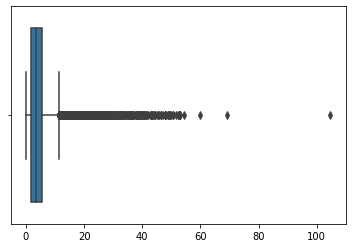

In [11]:
sns.boxplot(torch.abs(all_errors).detach())

<AxesSubplot:>

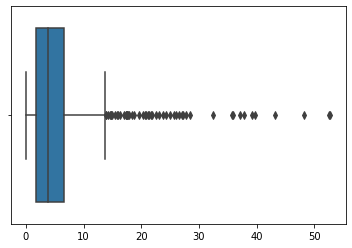

In [14]:
sns.boxplot(torch.abs(last_errors).detach())

<AxesSubplot:>

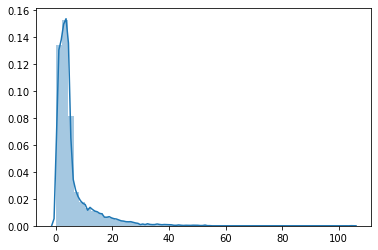

In [17]:
sns.distplot(torch.abs(all_errors).detach())

<AxesSubplot:>

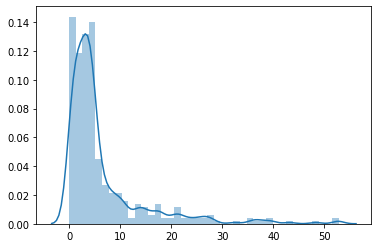

In [16]:
sns.distplot(torch.abs(last_errors).detach())

## Multiplying Functions

In [249]:
def sigmoid(x,l=0.1,s=0.1,b = 1,norm =1,m=1):
    d = x**norm
    return (b+torch.tanh((d-l)/s))/m


def rational_quadratic_kernel(x, sigma =1, alpha= 0.1, lengthscale = 0.01,norm = 1):
#     d = x ** norm
    d =x
    return (sigma ** 2) *(1+((d**2)/(alpha*lengthscale)))**(-alpha)





In [303]:
start = time.time()
for i in range(100000000):
    pass
end = time.time()

time_passed = end - start
time_passed

4.4979283809661865

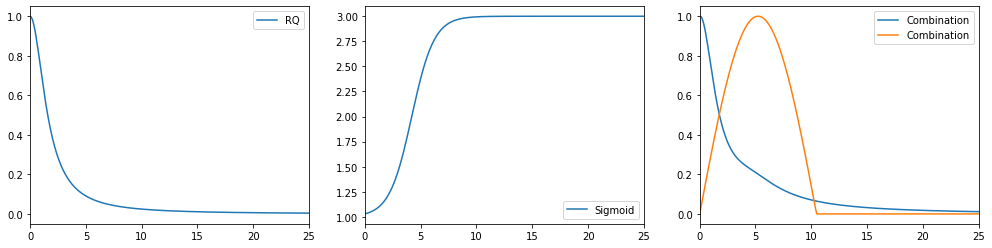

In [295]:
t =torch.arange(0,200,0.1)+0.000001
val = rational_quadratic_kernel(t,sigma= 1.0, lengthscale = 2.5, alpha = 1)
val_s = sigmoid((t),l =4.2,s= 2.0,norm =1,b=2.0,m=1)
values = val_s*val

values = (values - values.min())/(values.max()-values.min())
fig, axes = plt.subplots(1, 3,figsize=(17,4))
real_values = sin_kernel(t)
real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())


# for ax in axes:
#     ax.plot(t,values,label='Predicted')
# #     ax.plot(t,real_values,label='Real')
#     ax.legend()
    
    
axes[0].plot(t,val,label='RQ')
axes[1].plot(t,val_s,label='Sigmoid')
axes[2].plot(t,values,label='Combination')
axes[2].plot(t,real_values,label='Combination')

for ax in axes:
    ax.set_xlim(0, 25)
    ax.legend()
    


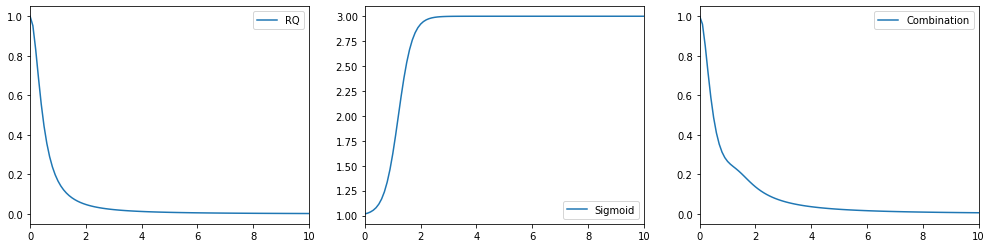

In [108]:
t =torch.arange(0,200,0.1)+0.000001
val = rational_quadratic_kernel(t,sigma= 1.0, lengthscale = 0.2, alpha = 1)
val_s = sigmoid((t),l =1.2,s= 0.5,norm =1,b=2.0,m=1)
values = val_s*val

values = (values - values.min())/(values.max()-values.min())
fig, axes = plt.subplots(1, 3,figsize=(17,4))
real_values = sin_kernel(t)
real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())


# for ax in axes:
#     ax.plot(t,values,label='Predicted')
# #     ax.plot(t,real_values,label='Real')
#     ax.legend()
    
    
axes[0].plot(t,val,label='RQ')
axes[1].plot(t,val_s,label='Sigmoid')
axes[2].plot(t,values,label='Combination')
for ax in axes:
    ax.set_xlim(0, 10)
    ax.legend()
    


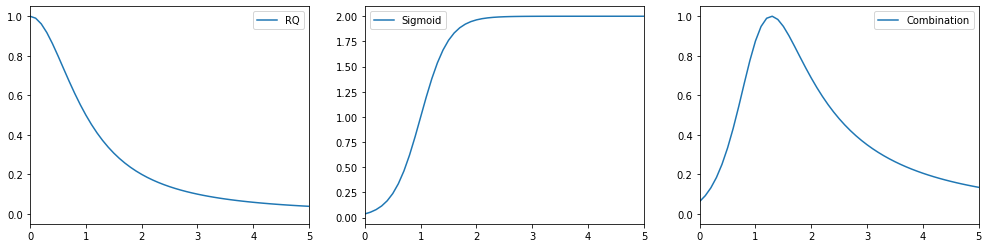

In [247]:
t =torch.arange(0,200,0.1)+0.000001
val = rational_quadratic_kernel(t,sigma= 1.0, lengthscale = 1.0, alpha = 1)
val_s = sigmoid((t),l =1.0,s= 0.5,norm =1,b=1.0,m=1)
values = val_s*val

values = (values - values.min())/(values.max()-values.min())
fig, axes = plt.subplots(1, 3,figsize=(17,4))
real_values = sin_kernel(t)
real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())


# for ax in axes:
#     ax.plot(t,values,label='Predicted')
# #     ax.plot(t,real_values,label='Real')
#     ax.legend()
    
    
axes[0].plot(t,val,label='RQ')
axes[1].plot(t,val_s,label='Sigmoid')
axes[2].plot(t,values,label='Combination')
for ax in axes:
    ax.set_xlim(0, 5)
    ax.legend()
    


In [259]:
    
def sin_kernel(t):
    

    t_c = np.copy(t)
    t_c[t_c>15] =0
    sin = np.sin(0.3*t_c)/9
    sin[sin <0] =0
    return sin

In [260]:
real_values = sin_kernel(t)
# real_values = (real_values - real_values.min())/(real_values.max()-real_values.min())

(0.0, 50.0)

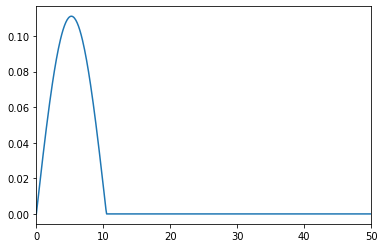

In [261]:
fig, ax = plt.subplots(1, 1)
ax.plot(t,real_values)
ax.set_xlim(0, 50)

In [256]:
real_values

array([0.        , 0.00333283, 0.00666267, 0.00998651, 0.01330136,
       0.01660424, 0.01989217, 0.02316221, 0.0264114 , 0.02963683,
       0.03283558, 0.03600478, 0.03914158, 0.04224316, 0.04530672,
       0.0483295 , 0.0513088 , 0.05424192, 0.05712622, 0.05995912,
       0.06273805, 0.06546053, 0.06812409, 0.07072635, 0.07326496,
       0.07573764, 0.07814216, 0.08047635, 0.08273812, 0.08492544,
       0.08703632, 0.08906888, 0.09102129, 0.09289178, 0.09467867,
       0.09638036, 0.09799531, 0.09952208, 0.10095928, 0.10230562,
       0.1035599 , 0.10472098, 0.10578782, 0.10675945, 0.10763501,
       0.10841371, 0.10909484, 0.10967779, 0.11016204, 0.11054715,
       0.11083278, 0.11101866, 0.11110464, 0.11109062, 0.11097664,
       0.11076278, 0.11044924, 0.11003631, 0.10952435, 0.10891383,
       0.10820529, 0.10739938, 0.10649681, 0.1054984 , 0.10440505,
       0.10321775, 0.10193755, 0.10056562, 0.09910318, 0.09755156,
       0.09591215, 0.09418643, 0.09237594, 0.09048232, 0.08850